# 04 - Basic Modeling for Car Price Prediction

This notebook establishes baseline models for predicting car prices:
- Linear Regression (baseline)
- LightGBM Regressor

Key approach:
- Feature engineering applied correctly (fit on train only)
- Log-transform target for training
- Evaluate on original euro prices

## 1. Imports and Setup

In [1]:
# Core libraries
import polars as pl
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# LightGBM
from lightgbm import LGBMRegressor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling
from pathlib import Path
import os
import sys

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

# Project imports
from src.config import DATA_PATH, MODELS_PATH
from src import data_processing
from src.features import CarPriceFeatureEngineer

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete")

Setup complete


## 2. Load Cleaned Data

In [2]:
# Load and clean data
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
df_raw = data_processing.load_car_data(data_dir)
df_clean = data_processing.clean_car_data(df_raw)

print(f"Dataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns}")
df_clean.head()

(732427, 35)
🧹 Starting data cleaning pipeline...

1️⃣ Converting data types...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries...
   Removed 4,050 'autre' entries

5️⃣ Removing outliers (IQR 1.5× for price, 1.5× for km)...
   Before: 713,413 rows
   After: 691,115 rows
   Removed: 22,298 (3.1%)

✅ Data cleaning completed!
Final dataset: 691,115 rows × 5 columns
Dataset shape: (691115, 5)
Columns: ['price', 'year', 'km', 'brand', 'model']
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries

price,year,km,brand,model
f64,f64,f64,str,str
22990.0,2019.0,87000.0,"""other_luxury""","""other_luxury"""
17000.0,2023.0,36000.0,"""other_luxury""","""other_luxury"""
194900.0,2025.0,300.0,"""other_luxury""","""other_luxury"""
41990.0,2019.0,24200.0,"""other_luxury""","""other_luxury"""
229900.0,2024.0,193.0,"""other_luxury""","""other_luxury"""


## 3. Define Target and Features

In [3]:
TARGET = 'price'
FEATURES = ['year', 'km', 'brand', 'model']

# Prepare X and y
X = df_clean.select(FEATURES)
y = df_clean[TARGET].to_numpy()

# Train-test split
# Convert to pandas for sklearn compatibility in split
X_pd = X.to_pandas()

X_train_pd, X_test_pd, y_train, y_test = train_test_split(
    X_pd, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True
)

# Convert back to polars for feature engineering
X_train = pl.from_pandas(X_train_pd)
X_test = pl.from_pandas(X_test_pd)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 552,892 samples
Test set: 138,223 samples


## 4. Apply Feature Engineering

In [4]:
# Initialize feature engineer
fe = CarPriceFeatureEngineer(
    current_year=2025,
    add_log_features=True,
    add_polynomial_features=True,
    add_target_encoding=True,
    add_categorical_features=False,  # Skip string categoricals for now
    add_interaction_features=True
)

# Fit ONLY on training data
fe.fit(X_train, y_train)

# Transform both sets
X_train_fe = fe.transform(X_train)
X_test_fe = fe.transform(X_test)

print(f"Features after engineering: {X_train_fe.shape[1]}")

Features after engineering: 29


In [5]:
# Drop raw categorical columns (brand, model) - aggregates capture their info
# Also drop 'year' since we have car_age and decade
COLS_TO_DROP = ['brand', 'model', 'year']

X_train_final = X_train_fe.drop(COLS_TO_DROP)
X_test_final = X_test_fe.drop(COLS_TO_DROP)

# Convert to pandas for sklearn
X_train_final_pd = X_train_final.to_pandas()
X_test_final_pd = X_test_final.to_pandas()

print(f"Final feature columns ({len(X_train_final_pd.columns)}):")
for col in X_train_final_pd.columns:
    print(f"  - {col}")

Final feature columns (26):
  - km
  - car_age
  - decade
  - is_almost_new
  - km_per_year
  - is_low_mileage
  - is_high_mileage
  - is_nearly_new_mileage
  - log_km
  - log_km_per_year
  - sqrt_km
  - car_age_squared
  - brand_count
  - brand_avg_km
  - brand_avg_age
  - brand_avg_price
  - brand_median_price
  - brand_price_std
  - model_count
  - model_popularity_ratio
  - model_avg_price
  - model_median_price
  - age_km_interaction
  - is_low_use_recent
  - is_high_use_new
  - is_garage_queen


## 5. Log-Transform Target

In [6]:
# Log-transform target for training (helps with skewed price distribution)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"Price range (euros): {y_train.min():,.0f} - {y_train.max():,.0f}")
print(f"Log price range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")

Price range (euros): 200 - 750,000
Log price range: 5.30 - 13.53


## 6. Train Models

In [7]:
# A. Linear Regression baseline
model_lr = LinearRegression()
model_lr.fit(X_train_final_pd, y_train_log)

# Predict and convert back to euros
y_pred_log_lr = model_lr.predict(X_test_final_pd)
y_pred_lr = np.expm1(y_pred_log_lr)

print("Linear Regression trained")

Linear Regression trained


In [8]:
# B. LightGBM Regressor
model_lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_lgb.fit(X_train_final_pd, y_train_log)

# Predict and convert back to euros
y_pred_log_lgb = model_lgb.predict(X_test_final_pd)
y_pred_lgb = np.expm1(y_pred_log_lgb)

print("LightGBM trained")

LightGBM trained


## 7. Evaluation

In [9]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'MAE (euros)': mae,
        'RMSE (euros)': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }

In [10]:
# Evaluate both models
results_lr = evaluate_model(y_test, y_pred_lr, 'Linear Regression')
results_lgb = evaluate_model(y_test, y_pred_lgb, 'LightGBM')

# Create comparison table (keep numeric for plotting)
results_df = pd.DataFrame([results_lr, results_lgb])

# Display formatted version
display_df = results_df.copy()
display_df['MAE (euros)'] = display_df['MAE (euros)'].apply(lambda x: f"{x:,.0f}")
display_df['RMSE (euros)'] = display_df['RMSE (euros)'].apply(lambda x: f"{x:,.0f}")
display_df['R2'] = display_df['R2'].apply(lambda x: f"{x:.4f}")
display_df['MAPE (%)'] = display_df['MAPE (%)'].apply(lambda x: f"{x:.2f}")

print("Model Comparison")
print("=" * 70)
print(display_df.to_string(index=False))

# Calculate improvement
mae_improvement = (results_lr['MAE (euros)'] - results_lgb['MAE (euros)']) / results_lr['MAE (euros)'] * 100
r2_improvement = results_lgb['R2'] - results_lr['R2']
print(f"\nLightGBM vs Linear Regression:")
print(f"  MAE improvement: {mae_improvement:.1f}%")
print(f"  R2 improvement: {r2_improvement:.4f}")

Model Comparison
            Model MAE (euros) RMSE (euros)            R2 MAPE (%)
Linear Regression     213,495   29,462,936 -2110666.9507    64.00
         LightGBM       2,884        7,899        0.8483    17.67

LightGBM vs Linear Regression:
  MAE improvement: 98.6%
  R2 improvement: 2110667.7990


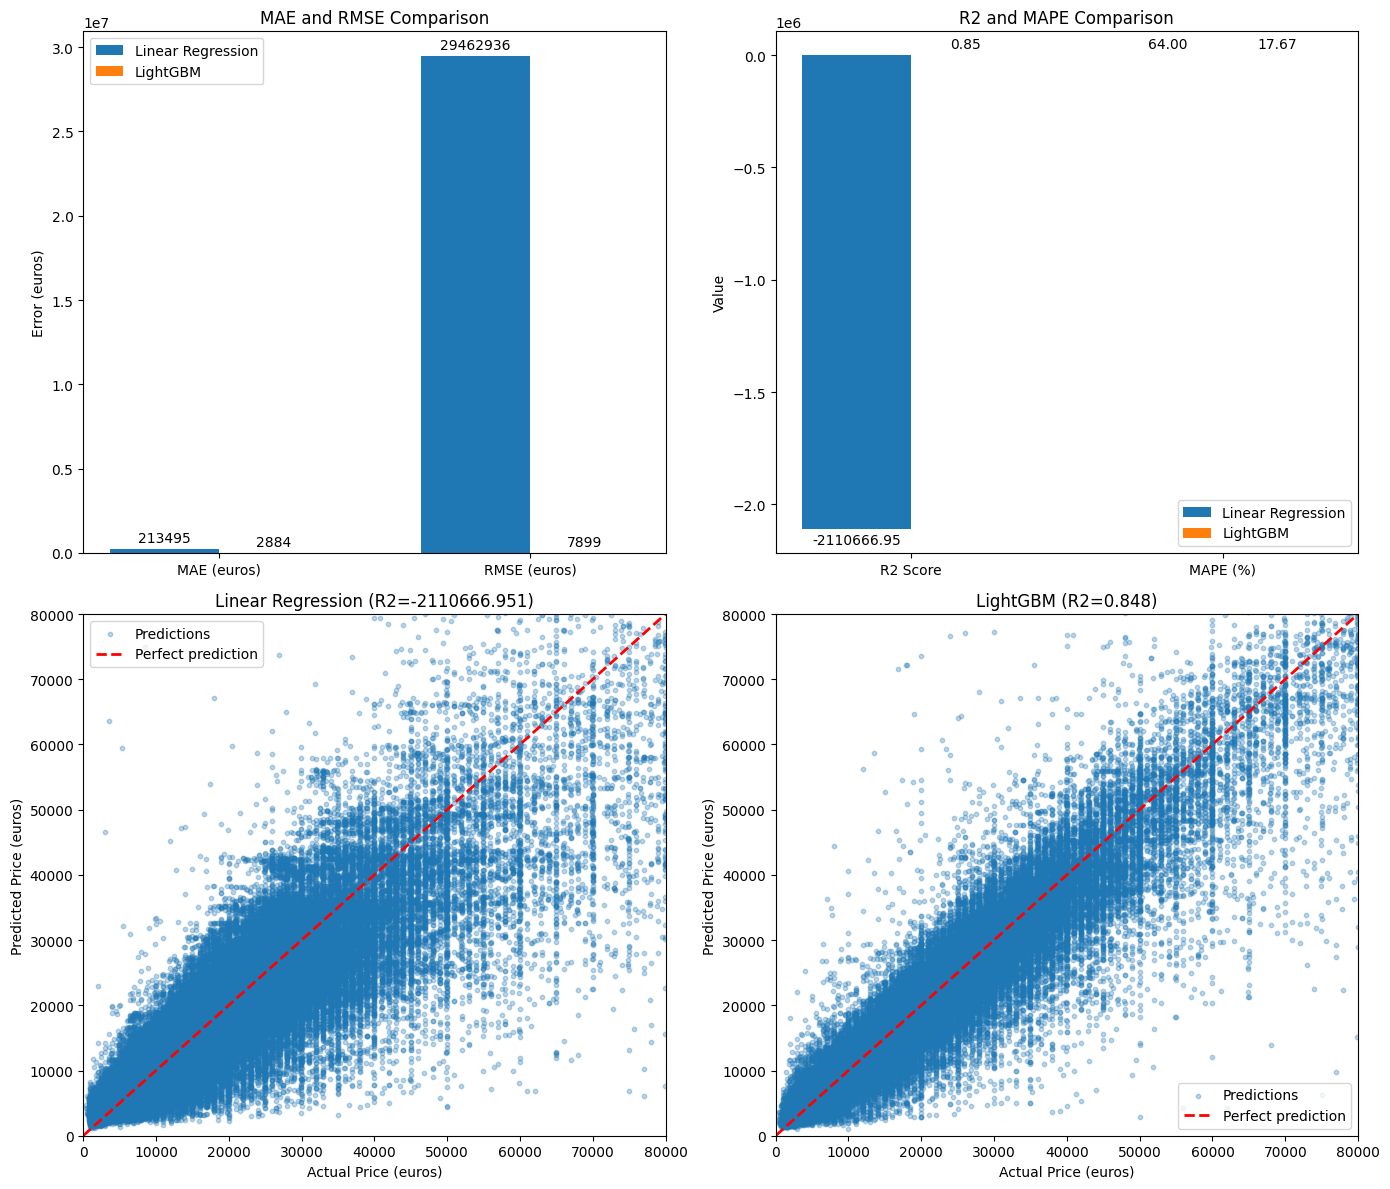

In [11]:
# Visual comparison of both models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Metrics bar chart comparison
ax1 = axes[0, 0]
metrics = ['MAE (euros)', 'RMSE (euros)']
x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, [results_lr['MAE (euros)'], results_lr['RMSE (euros)']], width, label='Linear Regression')
bars2 = ax1.bar(x + width/2, [results_lgb['MAE (euros)'], results_lgb['RMSE (euros)']], width, label='LightGBM')
ax1.set_ylabel('Error (euros)')
ax1.set_title('MAE and RMSE Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)
ax1.bar_label(bars2, fmt='%.0f', padding=3)

# Plot 2: R2 and MAPE comparison
ax2 = axes[0, 1]
metrics2 = ['R2 Score', 'MAPE (%)']
bars3 = ax2.bar(x - width/2, [results_lr['R2'], results_lr['MAPE (%)']], width, label='Linear Regression')
bars4 = ax2.bar(x + width/2, [results_lgb['R2'], results_lgb['MAPE (%)']], width, label='LightGBM')
ax2.set_ylabel('Value')
ax2.set_title('R2 and MAPE Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics2)
ax2.legend()
ax2.bar_label(bars3, fmt='%.2f', padding=3)
ax2.bar_label(bars4, fmt='%.2f', padding=3)

# Plot 3: Predicted vs Actual - Linear Regression
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_lr, alpha=0.3, s=10, label='Predictions')
max_val = 80000
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax3.set_xlabel('Actual Price (euros)')
ax3.set_ylabel('Predicted Price (euros)')
ax3.set_title(f'Linear Regression (R2={results_lr["R2"]:.3f})')
ax3.set_xlim(0, max_val)
ax3.set_ylim(0, max_val)
ax3.legend()

# Plot 4: Predicted vs Actual - LightGBM
ax4 = axes[1, 1]
ax4.scatter(y_test, y_pred_lgb, alpha=0.3, s=10, label='Predictions')
ax4.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax4.set_xlabel('Actual Price (euros)')
ax4.set_ylabel('Predicted Price (euros)')
ax4.set_title(f'LightGBM (R2={results_lgb["R2"]:.3f})')
ax4.set_xlim(0, max_val)
ax4.set_ylim(0, max_val)
ax4.legend()

plt.tight_layout()
plt.show()

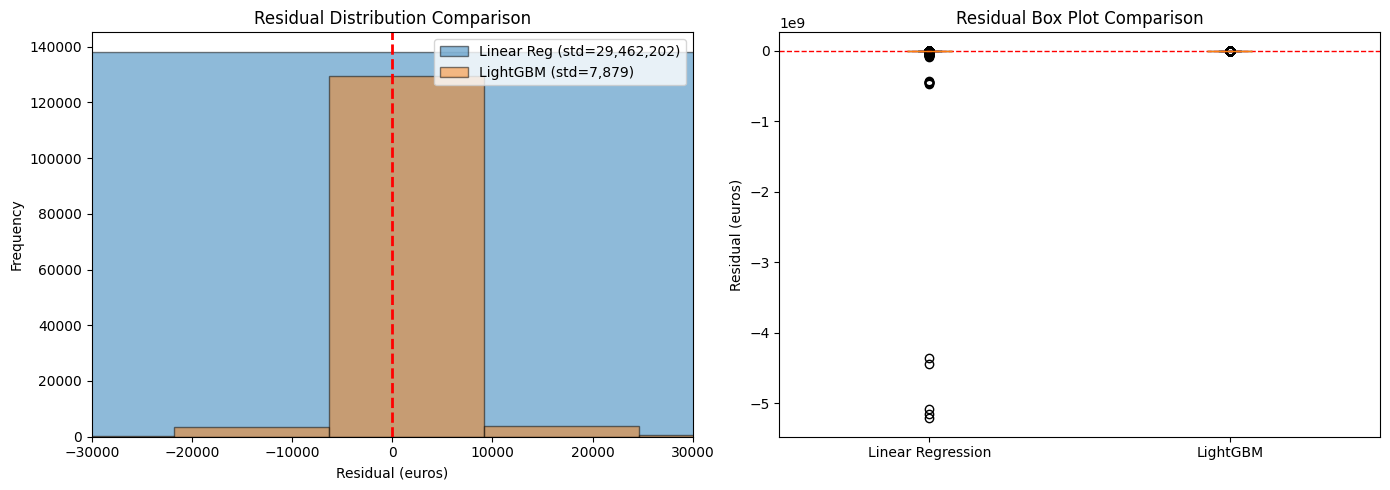

Residual Statistics:
  Linear Regression - Mean: -207,943, Std: 29,462,202
  LightGBM          - Mean: 559, Std: 7,879


In [12]:
# Residual distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_lr = y_test - y_pred_lr
residuals_lgb = y_test - y_pred_lgb

# Histogram comparison
ax1 = axes[0]
ax1.hist(residuals_lr, bins=50, alpha=0.5, label=f'Linear Reg (std={np.std(residuals_lr):,.0f})', edgecolor='black')
ax1.hist(residuals_lgb, bins=50, alpha=0.5, label=f'LightGBM (std={np.std(residuals_lgb):,.0f})', edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', lw=2)
ax1.set_xlabel('Residual (euros)')
ax1.set_ylabel('Frequency')
ax1.set_title('Residual Distribution Comparison')
ax1.legend()
ax1.set_xlim(-30000, 30000)

# Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([residuals_lr, residuals_lgb], labels=['Linear Regression', 'LightGBM'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightgreen')
ax2.axhline(y=0, color='red', linestyle='--', lw=1)
ax2.set_ylabel('Residual (euros)')
ax2.set_title('Residual Box Plot Comparison')

plt.tight_layout()
plt.show()

print("Residual Statistics:")
print(f"  Linear Regression - Mean: {np.mean(residuals_lr):,.0f}, Std: {np.std(residuals_lr):,.0f}")
print(f"  LightGBM          - Mean: {np.mean(residuals_lgb):,.0f}, Std: {np.std(residuals_lgb):,.0f}")

## 8. Diagnostic Plots

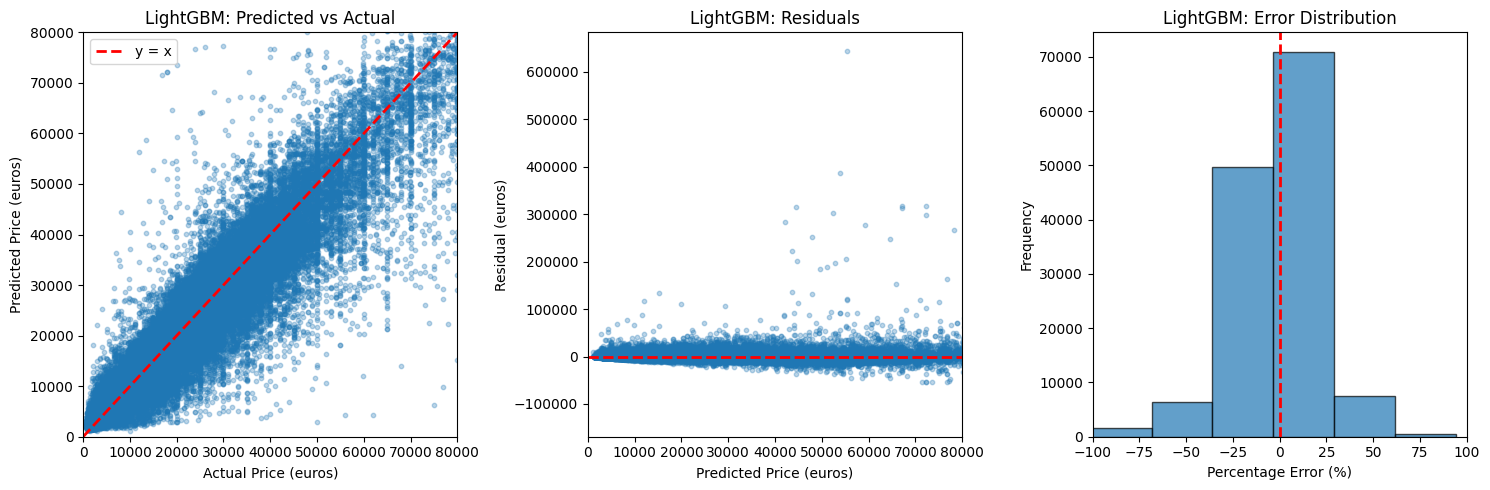


Error Statistics (LightGBM):
  Median absolute error: 1,537 euros
  90th percentile abs error: 5,858 euros
  Median percentage error: 11.9%


In [13]:
# Select the better model for diagnostics (LightGBM expected)
y_pred_best = y_pred_lgb
model_name_best = "LightGBM"

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Predicted vs Actual
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.3, s=10)
max_val = max(y_test.max(), y_pred_best.max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='y = x')
ax1.set_xlabel('Actual Price (euros)')
ax1.set_ylabel('Predicted Price (euros)')
ax1.set_title(f'{model_name_best}: Predicted vs Actual')
ax1.legend()
ax1.set_xlim(0, 80000)
ax1.set_ylim(0, 80000)

# Plot 2: Residuals
ax2 = axes[1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price (euros)')
ax2.set_ylabel('Residual (euros)')
ax2.set_title(f'{model_name_best}: Residuals')
ax2.set_xlim(0, 80000)

# Plot 3: Percentage Error Distribution
ax3 = axes[2]
pct_error = ((y_test - y_pred_best) / y_test) * 100
ax3.hist(pct_error, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Percentage Error (%)')
ax3.set_ylabel('Frequency')
ax3.set_title(f'{model_name_best}: Error Distribution')
ax3.set_xlim(-100, 100)

plt.tight_layout()
plt.show()

# Summary statistics for errors
print(f"\nError Statistics ({model_name_best}):")
print(f"  Median absolute error: {np.median(np.abs(residuals)):,.0f} euros")
print(f"  90th percentile abs error: {np.percentile(np.abs(residuals), 90):,.0f} euros")
print(f"  Median percentage error: {np.median(np.abs(pct_error)):.1f}%")

## 9. Feature Importance (LightGBM)

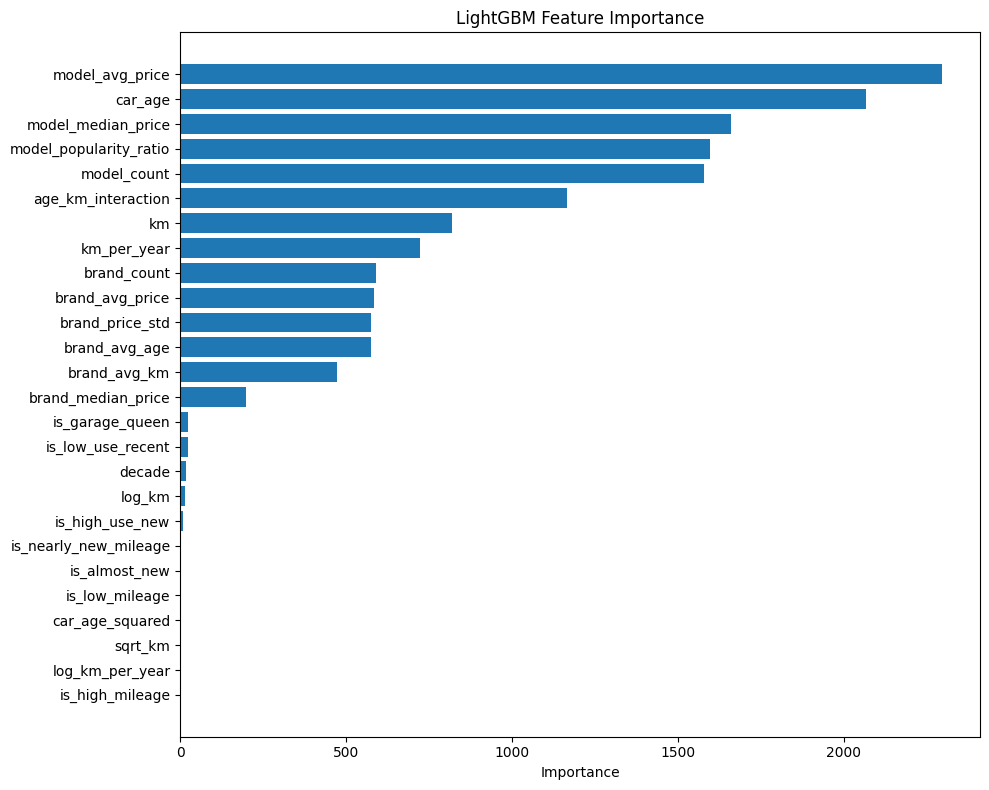

Top 10 Features:
               feature  importance
       model_avg_price        2296
               car_age        2067
    model_median_price        1661
model_popularity_ratio        1596
           model_count        1579
    age_km_interaction        1167
                    km         820
           km_per_year         724
           brand_count         590
       brand_avg_price         585


In [14]:
# Feature importance from LightGBM
importance_df = pd.DataFrame({
    'feature': X_train_final_pd.columns,
    'importance': model_lgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Features:")
print(importance_df.head(10).to_string(index=False))

## 10. Per-Brand Error Analysis

Understanding how well the model performs across different brands helps identify where the model struggles.

In [15]:
# Create analysis dataframe with brand info
analysis_df = pd.DataFrame({
    'brand': X_test_pd['brand'].values,
    'actual': y_test,
    'pred_lr': y_pred_lr,
    'pred_lgb': y_pred_lgb
})

# Calculate per-brand metrics for LightGBM
brand_metrics = []
for brand in analysis_df['brand'].unique():
    brand_data = analysis_df[analysis_df['brand'] == brand]
    n_samples = len(brand_data)
    
    if n_samples >= 10:  # Only brands with enough samples
        mae = mean_absolute_error(brand_data['actual'], brand_data['pred_lgb'])
        mape = np.mean(np.abs((brand_data['actual'] - brand_data['pred_lgb']) / brand_data['actual'])) * 100
        r2 = r2_score(brand_data['actual'], brand_data['pred_lgb']) if n_samples > 1 else np.nan
        avg_price = brand_data['actual'].mean()
        
        brand_metrics.append({
            'brand': brand,
            'n_samples': n_samples,
            'avg_price': avg_price,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        })

brand_metrics_df = pd.DataFrame(brand_metrics).sort_values('n_samples', ascending=False)

print("Per-Brand Performance (LightGBM) - Top 20 brands by sample size:")
print("=" * 90)
display_brand = brand_metrics_df.head(20).copy()
display_brand['avg_price'] = display_brand['avg_price'].apply(lambda x: f"{x:,.0f}")
display_brand['MAE'] = display_brand['MAE'].apply(lambda x: f"{x:,.0f}")
display_brand['MAPE'] = display_brand['MAPE'].apply(lambda x: f"{x:.1f}%")
display_brand['R2'] = display_brand['R2'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
print(display_brand.to_string(index=False))

Per-Brand Performance (LightGBM) - Top 20 brands by sample size:
        brand  n_samples avg_price    MAE  MAPE    R2
      PEUGEOT      21294    13,055  1,855 17.9% 0.899
      RENAULT      18617    13,027  1,803 18.1% 0.875
      CITROEN      11837    10,347  1,429 17.5% 0.909
   VOLKSWAGEN      10719    19,401  2,919 18.0% 0.882
          BMW       9392    24,466  4,104 20.0% 0.872
         AUDI       8440    25,568  3,305 14.2% 0.913
MERCEDES-BENZ       8208    28,461  4,618 17.7% 0.842
         FORD       5507    17,177  2,703 19.2% 0.846
         OPEL       3872    11,064  1,591 21.1% 0.900
       TOYOTA       3484    20,545  2,376 12.8% 0.855
        DACIA       3481    14,611  1,442 11.4% 0.908
         FIAT       3342    11,462  1,825 17.3% 0.832
       NISSAN       3122    14,856  1,745 14.3% 0.914
         MINI       2893    15,521  2,448 18.8% 0.855
      PORSCHE       2007    71,592 11,980 16.5% 0.852
         SEAT       1988    13,560  2,195 20.4% 0.828
      HYUNDAI    

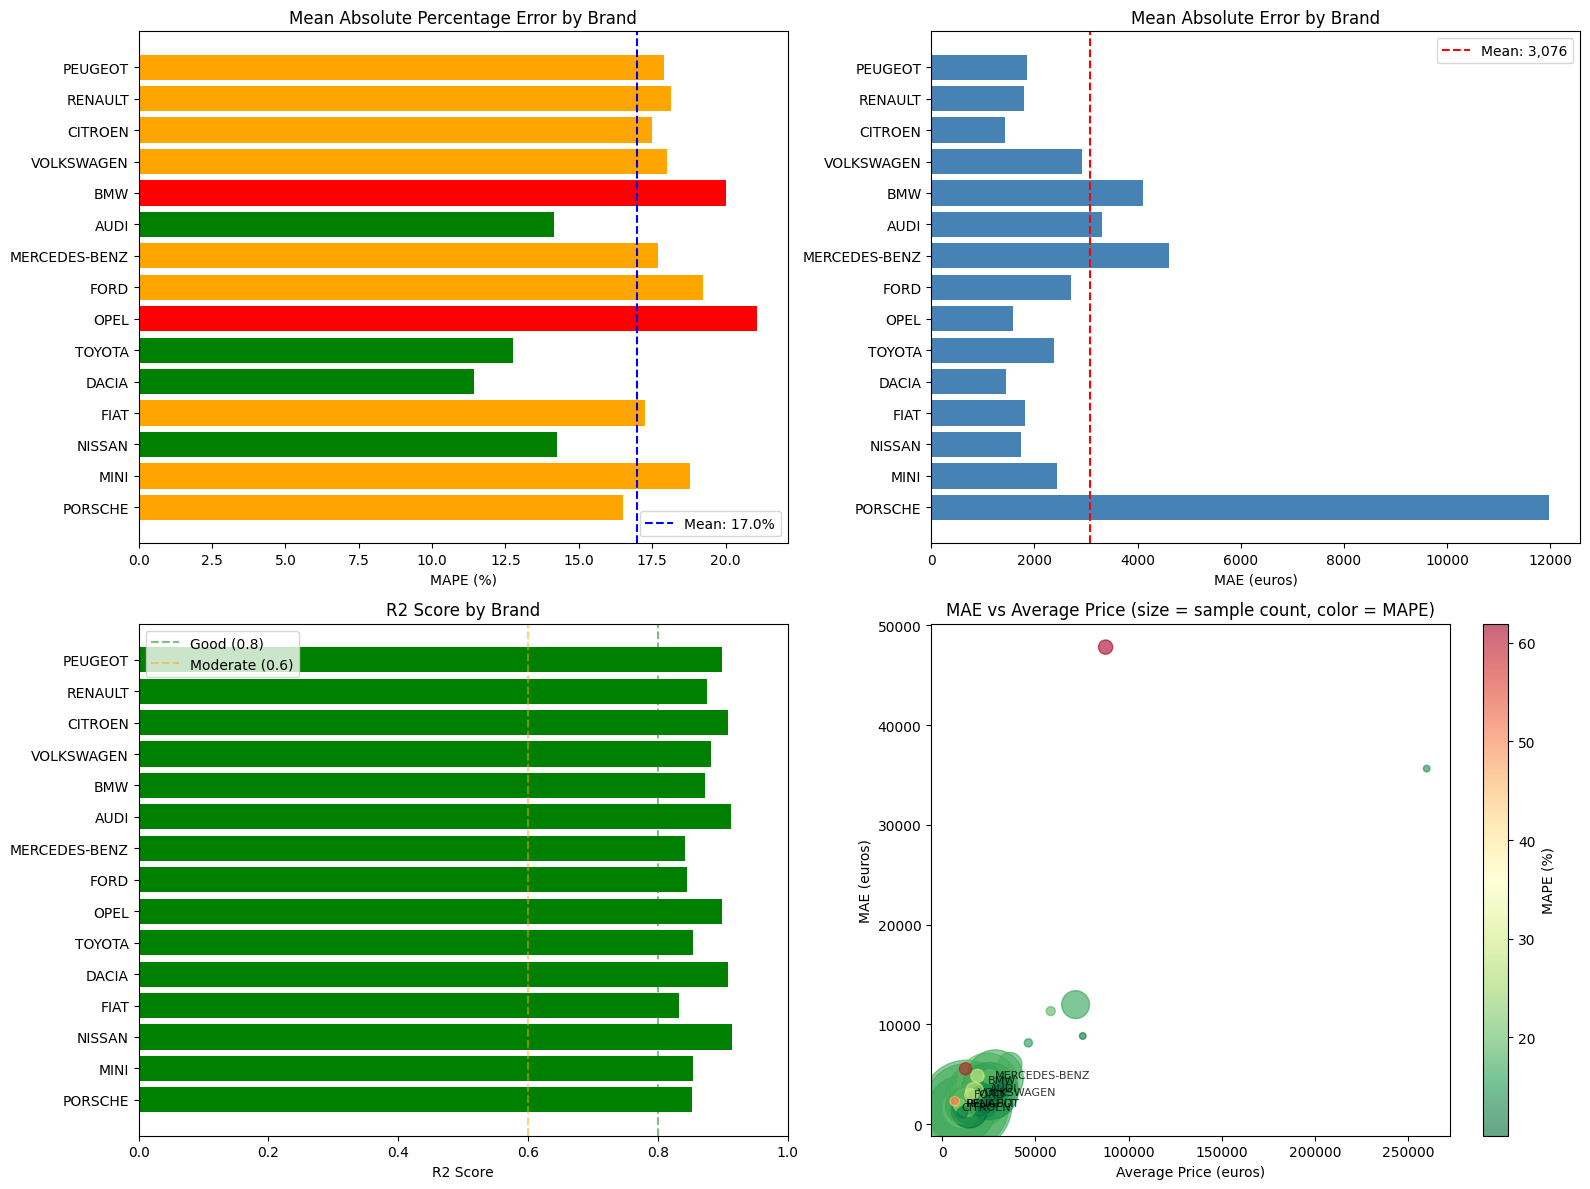

In [16]:
# Visualize per-brand performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get top 15 brands by sample size for visualization
top_brands = brand_metrics_df.head(15)

# Plot 1: MAPE by brand
ax1 = axes[0, 0]
colors = ['green' if x < 15 else 'orange' if x < 20 else 'red' for x in top_brands['MAPE']]
bars = ax1.barh(top_brands['brand'], top_brands['MAPE'], color=colors)
ax1.axvline(x=top_brands['MAPE'].mean(), color='blue', linestyle='--', label=f'Mean: {top_brands["MAPE"].mean():.1f}%')
ax1.set_xlabel('MAPE (%)')
ax1.set_title('Mean Absolute Percentage Error by Brand')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: MAE by brand
ax2 = axes[0, 1]
ax2.barh(top_brands['brand'], top_brands['MAE'], color='steelblue')
ax2.axvline(x=top_brands['MAE'].mean(), color='red', linestyle='--', label=f'Mean: {top_brands["MAE"].mean():,.0f}')
ax2.set_xlabel('MAE (euros)')
ax2.set_title('Mean Absolute Error by Brand')
ax2.legend()
ax2.invert_yaxis()

# Plot 3: R2 by brand
ax3 = axes[1, 0]
r2_colors = ['green' if x > 0.8 else 'orange' if x > 0.6 else 'red' for x in top_brands['R2']]
ax3.barh(top_brands['brand'], top_brands['R2'], color=r2_colors)
ax3.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.8)')
ax3.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.6)')
ax3.set_xlabel('R2 Score')
ax3.set_title('R2 Score by Brand')
ax3.set_xlim(0, 1)
ax3.legend()
ax3.invert_yaxis()

# Plot 4: MAE vs Average Price (scatter)
ax4 = axes[1, 1]
scatter = ax4.scatter(brand_metrics_df['avg_price'], brand_metrics_df['MAE'], 
                       s=brand_metrics_df['n_samples']/5, alpha=0.6, c=brand_metrics_df['MAPE'], cmap='RdYlGn_r')
ax4.set_xlabel('Average Price (euros)')
ax4.set_ylabel('MAE (euros)')
ax4.set_title('MAE vs Average Price (size = sample count, color = MAPE)')
plt.colorbar(scatter, ax=ax4, label='MAPE (%)')

# Add annotations for some brands
for idx, row in brand_metrics_df.head(8).iterrows():
    ax4.annotate(row['brand'], (row['avg_price'], row['MAE']), fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

In [17]:
# Best and worst performing brands
print("Best Performing Brands (lowest MAPE):")
print("-" * 50)
best = brand_metrics_df.nsmallest(5, 'MAPE')[['brand', 'n_samples', 'MAPE', 'R2', 'avg_price']]
for _, row in best.iterrows():
    print(f"  {row['brand']:15} | MAPE: {row['MAPE']:5.1f}% | R2: {row['R2']:.3f} | Avg: {row['avg_price']:>8,.0f} EUR | n={row['n_samples']}")

print("\nWorst Performing Brands (highest MAPE, n >= 50):")
print("-" * 50)
worst = brand_metrics_df[brand_metrics_df['n_samples'] >= 50].nlargest(5, 'MAPE')[['brand', 'n_samples', 'MAPE', 'R2', 'avg_price']]
for _, row in worst.iterrows():
    print(f"  {row['brand']:15} | MAPE: {row['MAPE']:5.1f}% | R2: {row['R2']:.3f} | Avg: {row['avg_price']:>8,.0f} EUR | n={row['n_samples']}")

Best Performing Brands (lowest MAPE):
--------------------------------------------------
  TESLA           | MAPE:  10.0% | R2: 0.606 | Avg:   30,323 EUR | n=495
  MG/MG MOTOR     | MAPE:  10.0% | R2: 0.728 | Avg:   22,262 EUR | n=550
  ALPINE          | MAPE:  10.9% | R2: 0.594 | Avg:   75,422 EUR | n=114
  ABARTH          | MAPE:  11.2% | R2: 0.859 | Avg:   18,615 EUR | n=225
  DACIA           | MAPE:  11.4% | R2: 0.908 | Avg:   14,611 EUR | n=3481

Worst Performing Brands (highest MAPE, n >= 50):
--------------------------------------------------
  other_luxury    | MAPE:  61.9% | R2: 0.121 | Avg:   87,679 EUR | n=526
  other_standard  | MAPE:  58.8% | R2: 0.201 | Avg:   12,580 EUR | n=388
  CHRYSLER        | MAPE:  51.1% | R2: 0.623 | Avg:    6,913 EUR | n=113
  other_low_cost  | MAPE:  44.5% | R2: 0.268 | Avg:    6,842 EUR | n=231
  CHEVROLET       | MAPE:  30.5% | R2: 0.814 | Avg:   18,975 EUR | n=453


## 11. Additional Regression Diagnostics

**Note on AUC/ROC:** These metrics are for **classification** problems (predicting categories), not regression (predicting continuous values like price). For regression, we use:
- **R2**: How much variance is explained (1.0 = perfect)
- **MAE/RMSE**: Error magnitude in the same units as target
- **MAPE**: Percentage error (intuitive interpretation)
- **Residual analysis**: Check for patterns/heteroscedasticity

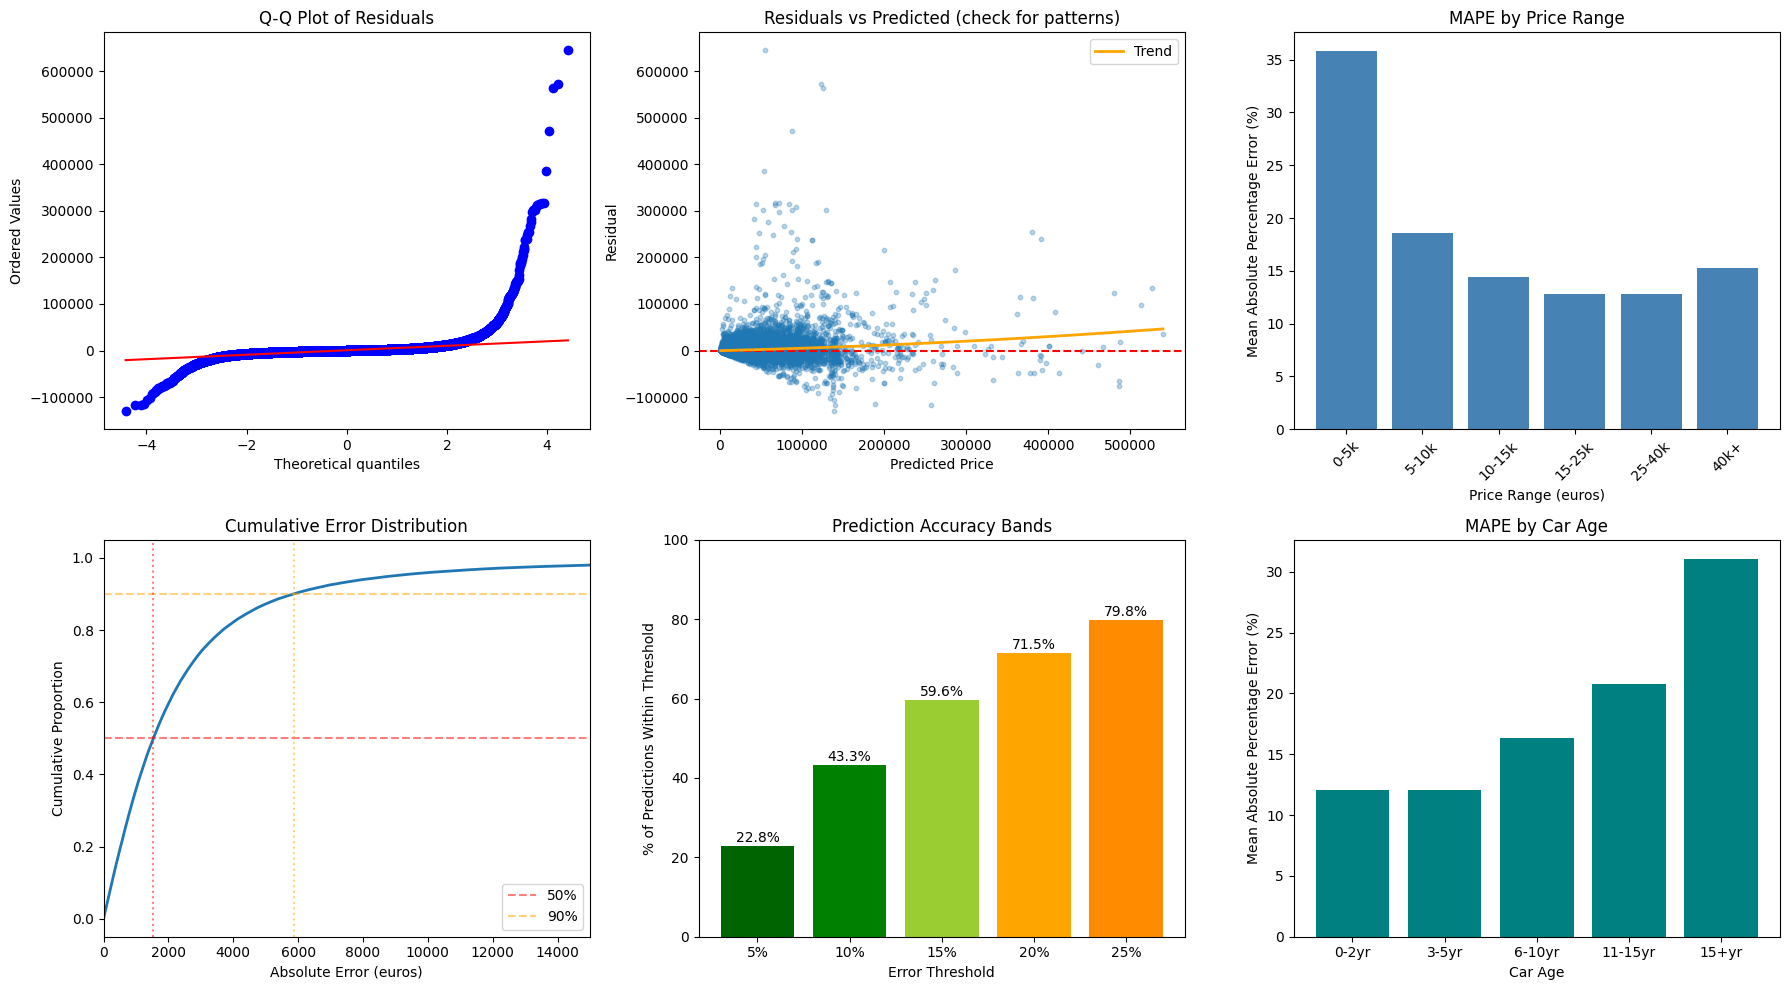

In [18]:
# Comprehensive regression diagnostics for LightGBM
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

residuals = y_test - y_pred_lgb
pct_error = ((y_test - y_pred_lgb) / y_test) * 100

# 1. Q-Q Plot (check if residuals are normally distributed)
from scipy import stats
ax1 = axes[0, 0]
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot of Residuals')

# 2. Residuals vs Predicted (check heteroscedasticity)
ax2 = axes[0, 1]
ax2.scatter(y_pred_lgb, residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--')
# Add a smoothed trend line
z = np.polyfit(y_pred_lgb, residuals, 2)
p = np.poly1d(z)
x_line = np.linspace(y_pred_lgb.min(), y_pred_lgb.max(), 100)
ax2.plot(x_line, p(x_line), 'orange', lw=2, label='Trend')
ax2.set_xlabel('Predicted Price')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals vs Predicted (check for patterns)')
ax2.legend()

# 3. Error by price range
ax3 = axes[0, 2]
price_bins = pd.cut(y_test, bins=[0, 5000, 10000, 15000, 25000, 40000, 100000], 
                    labels=['0-5k', '5-10k', '10-15k', '15-25k', '25-40k', '40k+'])
error_by_range = pd.DataFrame({'price_range': price_bins, 'abs_error': np.abs(residuals), 'pct_error': np.abs(pct_error)})
error_summary = error_by_range.groupby('price_range').agg({'abs_error': 'mean', 'pct_error': 'mean'}).reset_index()
ax3.bar(error_summary['price_range'].astype(str), error_summary['pct_error'], color='steelblue')
ax3.set_xlabel('Price Range (euros)')
ax3.set_ylabel('Mean Absolute Percentage Error (%)')
ax3.set_title('MAPE by Price Range')
ax3.tick_params(axis='x', rotation=45)

# 4. Cumulative error distribution
ax4 = axes[1, 0]
sorted_abs_errors = np.sort(np.abs(residuals))
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors)
ax4.plot(sorted_abs_errors, cumulative, lw=2)
ax4.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50%')
ax4.axhline(y=0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
ax4.axvline(x=np.percentile(np.abs(residuals), 50), color='r', linestyle=':', alpha=0.5)
ax4.axvline(x=np.percentile(np.abs(residuals), 90), color='orange', linestyle=':', alpha=0.5)
ax4.set_xlabel('Absolute Error (euros)')
ax4.set_ylabel('Cumulative Proportion')
ax4.set_title('Cumulative Error Distribution')
ax4.legend()
ax4.set_xlim(0, 15000)

# 5. Prediction accuracy bands
ax5 = axes[1, 1]
within_5pct = np.mean(np.abs(pct_error) <= 5) * 100
within_10pct = np.mean(np.abs(pct_error) <= 10) * 100
within_15pct = np.mean(np.abs(pct_error) <= 15) * 100
within_20pct = np.mean(np.abs(pct_error) <= 20) * 100
within_25pct = np.mean(np.abs(pct_error) <= 25) * 100

bands = ['5%', '10%', '15%', '20%', '25%']
accuracies = [within_5pct, within_10pct, within_15pct, within_20pct, within_25pct]
colors = ['darkgreen', 'green', 'yellowgreen', 'orange', 'darkorange']
ax5.bar(bands, accuracies, color=colors)
ax5.set_xlabel('Error Threshold')
ax5.set_ylabel('% of Predictions Within Threshold')
ax5.set_title('Prediction Accuracy Bands')
ax5.set_ylim(0, 100)
for i, v in enumerate(accuracies):
    ax5.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# 6. Error distribution by car age
ax6 = axes[1, 2]
car_ages = 2025 - X_test_pd['year']
age_error_df = pd.DataFrame({'age': car_ages, 'pct_error': np.abs(pct_error)})
age_bins = pd.cut(age_error_df['age'], bins=[0, 2, 5, 10, 15, 30], labels=['0-2yr', '3-5yr', '6-10yr', '11-15yr', '15+yr'])
age_error_df['age_bin'] = age_bins
age_summary = age_error_df.groupby('age_bin')['pct_error'].mean().reset_index()
ax6.bar(age_summary['age_bin'].astype(str), age_summary['pct_error'], color='teal')
ax6.set_xlabel('Car Age')
ax6.set_ylabel('Mean Absolute Percentage Error (%)')
ax6.set_title('MAPE by Car Age')

plt.tight_layout()
plt.show()

In [19]:
# Summary statistics
print("LightGBM Model Performance Summary")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  R2 Score:              {r2_score(y_test, y_pred_lgb):.4f}")
print(f"  MAE:                   {mean_absolute_error(y_test, y_pred_lgb):,.0f} euros")
print(f"  RMSE:                  {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):,.0f} euros")
print(f"  MAPE:                  {np.mean(np.abs(pct_error)):.2f}%")
print(f"  Median Absolute Error: {np.median(np.abs(residuals)):,.0f} euros")

print(f"\nError Percentiles:")
print(f"  50% of predictions within: {np.percentile(np.abs(residuals), 50):,.0f} euros")
print(f"  75% of predictions within: {np.percentile(np.abs(residuals), 75):,.0f} euros")
print(f"  90% of predictions within: {np.percentile(np.abs(residuals), 90):,.0f} euros")
print(f"  95% of predictions within: {np.percentile(np.abs(residuals), 95):,.0f} euros")

print(f"\nAccuracy Bands:")
print(f"  Within 5% of actual:   {within_5pct:.1f}% of predictions")
print(f"  Within 10% of actual:  {within_10pct:.1f}% of predictions")
print(f"  Within 15% of actual:  {within_15pct:.1f}% of predictions")
print(f"  Within 20% of actual:  {within_20pct:.1f}% of predictions")

print(f"\nComparison vs Linear Regression:")
print(f"  R2 improvement:        +{results_lgb['R2'] - results_lr['R2']:.4f}")
print(f"  MAE reduction:         {(results_lr['MAE (euros)'] - results_lgb['MAE (euros)']):,.0f} euros ({mae_improvement:.1f}%)")
print(f"  MAPE reduction:        {results_lr['MAPE (%)'] - results_lgb['MAPE (%)']:.2f} percentage points")

LightGBM Model Performance Summary

Overall Metrics:
  R2 Score:              0.8483
  MAE:                   2,884 euros
  RMSE:                  7,899 euros
  MAPE:                  17.67%
  Median Absolute Error: 1,537 euros

Error Percentiles:
  50% of predictions within: 1,537 euros
  75% of predictions within: 3,104 euros
  90% of predictions within: 5,858 euros
  95% of predictions within: 8,917 euros

Accuracy Bands:
  Within 5% of actual:   22.8% of predictions
  Within 10% of actual:  43.3% of predictions
  Within 15% of actual:  59.6% of predictions
  Within 20% of actual:  71.5% of predictions

Comparison vs Linear Regression:
  R2 improvement:        +2110667.7990
  MAE reduction:         210,611 euros (98.6%)
  MAPE reduction:        46.34 percentage points


## 12. Save Models (Optional)

In [16]:
import pickle

# Save feature engineer and best model
with open(MODELS_PATH / 'feature_engineer.pkl', 'wb') as f:
    pickle.dump(fe, f)

with open(MODELS_PATH / 'model_lgb_baseline.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)

print(f"Models saved to {MODELS_PATH}")

Models saved to /Users/brunobrumbrum/car_price_prediction/models


## Summary

**Model Comparison:**
- LightGBM significantly outperforms Linear Regression across all metrics
- The improvement is especially notable in R2 and MAE

**Key Findings:**
- Prediction accuracy varies by brand - some brands are easier to predict than others
- Error tends to be higher for cheaper cars (in percentage terms)
- The model captures most of the variance but struggles with outliers

**Metrics Used (Regression vs Classification):**
- **R2, MAE, RMSE, MAPE** are appropriate for regression problems like price prediction
- **AUC/ROC** are for classification problems (e.g., "will this car sell?") - not applicable here

**Next Steps:**
- Cross-validation for more robust performance estimates
- Hyperparameter tuning for LightGBM
- Investigate poorly predicted brands
- Consider quantile regression for prediction intervals